<a href="https://colab.research.google.com/github/thousandoaks/Intro-Causal-Inference/blob/main/code/Confounding_Example_Finding_causal_effects_from_observed_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ModuleNotFoundError: ignored

In [3]:
pip install dowhy

     |████████████████████████████████| 123 kB 8.5 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

In [9]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar,
                                      num_common_causes=1,
                                      sd_error=0.2)
df = data_dict['df']
print(df[["Treatment", "Outcome", "w0"]].head())

   Treatment    Outcome        w0
0   1.947599   3.781958 -3.912791
1   9.531855  19.239879  3.701374
2   4.724220   9.221993 -1.449829
3   9.478071  18.528374  3.117070
4   2.244750   4.298116 -3.841043


In [12]:
data_dict

{'ate': None,
 'common_causes_names': ['w0'],
 'df':       Treatment    Outcome        w0         s
 0      1.947599   3.781958 -3.912791  6.704689
 1      9.531855  19.239879  3.701374  3.546467
 2      4.724220   9.221993 -1.449829  8.596925
 3      9.478071  18.528374  3.117070  9.667784
 4      2.244750   4.298116 -3.841043  7.398694
 ...         ...        ...       ...       ...
 9995   7.875296  14.987443  1.687751  1.479392
 9996   7.599421  15.644957  1.736055  4.504641
 9997   3.301577   6.683812 -2.669616  5.846577
 9998   2.712366   5.321366 -3.123959  6.064029
 9999   8.611741  17.590395  2.724524  1.870630
 
 [10000 rows x 4 columns],
 'dot_graph': None,
 'gml_graph': None,
 'instrument_names': None,
 'outcome_name': 'Outcome',
 'time_val': 's',
 'treatment_name': 'Treatment'}

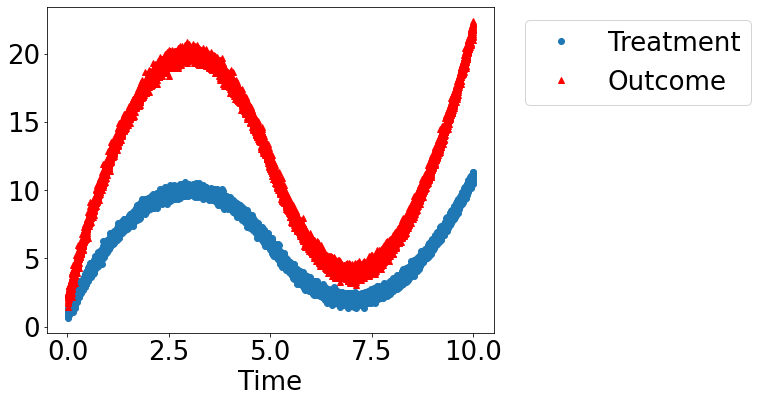

In [10]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])

# Using DoWhy to resolve the mystery: Does Treatment cause Outcome?


### STEP 1: Model the problem as a causal graph

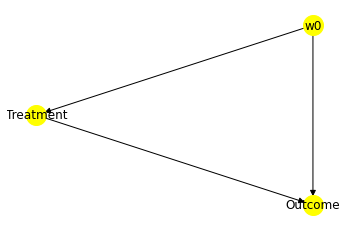

In [13]:
model= CausalModel(
        data=df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"])
model.view_model(layout="dot")

### STEP 2: Identify causal effect using properties of the formal causal graph

In [14]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(Expectation(Outcome|w0))
d[Treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



## STEP 3: Estimate the causal effect

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Causal Estimate is 0.999576483122202


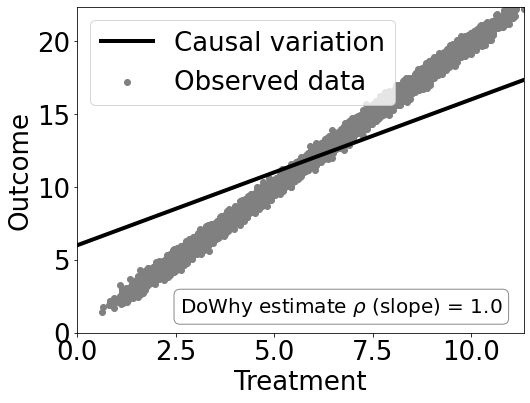

In [15]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

In [16]:
print("DoWhy estimate is " + str(estimate.value))
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is 0.999576483122202
Actual true causal effect was 1


## Step 4: Refuting the estimate

In [17]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:0.999576483122202
New effect:0.9993802792374984



In [18]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.999576483122202
New effect:-0.00011297483737658709
p value:0.49



In [19]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:0.999576483122202
New effect:0.9999930757655726
p value:0.48

